# Gold Next-Day Direction Prediction (with GPRD)

Predict whether **gold** closes higher the next day using lag/rolling features from gold, plus **silver** and **GPRD** as additional signals. Models are compared on a chronological hold-out test set, and the final model is shown in a small Gradio demo.

## 1. Problem

Binary classification: predict whether gold increases tomorrow.

$$
y_t =
\begin{cases}
1, & \text{if } P_{t+1} > P_t \\
0, & \text{otherwise}
\end{cases}
$$

## 2. Dataset

Columns used:
- `DATE`
- `GOLD_PRICE`
- `SILVER_PRICE`
- `GPRD`

Data is treated as a time series and is split chronologically.

In [81]:
# Imports + display settings

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

np.random.seed(42)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [82]:
# Load the dataset

csv_files = []
for root, _, files in os.walk("/kaggle/input"):
    for f in files:
        if f.lower().endswith(".csv"):
            p = os.path.join(root, f)
            try:
                size = os.path.getsize(p)
            except OSError:
                size = 0
            csv_files.append((size, p))

if not csv_files:
    raise FileNotFoundError("No CSV files found in /kaggle/input. Add your dataset via 'Add data'.")

csv_files = sorted(csv_files, reverse=True)
print("CSV candidates (largest first):")
for sz, p in csv_files[:10]:
    print(f" - {p} ({sz/1024:.1f} KB)")

CSV_PATH = csv_files[0][1]
print("\nUsing CSV_PATH:", CSV_PATH)

df = pd.read_csv(CSV_PATH)
print("Raw df shape:", df.shape)
display(df.head())

CSV candidates (largest first):
 - /kaggle/input/gold-silver-price-vs-geopolitical-risk-19852025/Gold-Silver-GeopoliticalRisk_HistoricalData.csv (979.2 KB)
 - /kaggle/input/gold-silver-price-vs-geopolitical-risk-19852025/All_Historical_Data_Separately/Gold Spot Price Daily.csv (485.8 KB)
 - /kaggle/input/gold-silver-price-vs-geopolitical-risk-19852025/All_Historical_Data_Separately/Geopolitical Risk Index Daily.csv (468.1 KB)
 - /kaggle/input/gold-silver-price-vs-geopolitical-risk-19852025/All_Historical_Data_Separately/Silver Spot Price Daily.csv (406.6 KB)

Using CSV_PATH: /kaggle/input/gold-silver-price-vs-geopolitical-risk-19852025/Gold-Silver-GeopoliticalRisk_HistoricalData.csv
Raw df shape: (10571, 15)


,DATE,GOLD_PRICE,GOLD_OPEN,GOLD_HIGH,GOLD_LOW,GOLD_CHANGE_%,SILVER_PRICE,SILVER_OPEN,SILVER_HIGH,SILVER_LOW,SILVER_CHANGE_%,GPRD,GPRD_ACT,GPRD_THREAT,EVENT
0,2025-09-10,3630.90,3633.61,3634.42,3620.90,-0.07,40.92,40.89,40.94,40.72,0.09,NaN,NaN,NaN,NaN
1,2025-09-09,3633.61,3637.10,3674.75,3625.33,-0.06,40.89,41.34,41.50,40.77,-1.13,NaN,NaN,NaN,NaN
2,2025-09-08,3635.84,3586.82,3646.60,3579.67,1.24,41.36,41.01,41.68,40.51,1.20,117.26,97.42,146.26,NaN
3,2025-09-07,3591.19,3592.07,3596.56,3586.95,0.12,40.86,41.00,41.01,40.76,-0.34,83.51,111.00,92.59,NaN
4,2025-09-05,3586.81,3547.00,3600.33,3540.05,1.15,41.01,40.69,41.44,40.55,0.76,166.42,110.61,224.05,NaN


In [83]:
# Clean + keep required columns

DATE_COL = "DATE"
GOLD_COL = "GOLD_PRICE"
SILV_COL = "SILVER_PRICE"
GPR_COL  = "GPRD"

required = {DATE_COL, GOLD_COL, SILV_COL, GPR_COL}
missing = required - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns: {missing}. Available columns: {df.columns.tolist()}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
for c in [GOLD_COL, SILV_COL, GPR_COL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)

print("Dtypes:\n", df[[DATE_COL, GOLD_COL, SILV_COL, GPR_COL]].dtypes)
print("\nMissing values:\n", df[[DATE_COL, GOLD_COL, SILV_COL, GPR_COL]].isna().sum())
print("\nMissing %:\n", (df[[DATE_COL, GOLD_COL, SILV_COL, GPR_COL]].isna().mean()*100).round(3))
print("\nShape after sort:", df.shape)
display(df[[DATE_COL, GOLD_COL, SILV_COL, GPR_COL]].head())

Dtypes:
 DATE            datetime64[ns]
GOLD_PRICE             float64
SILVER_PRICE           float64
GPRD                   float64
dtype: object

Missing values:
 DATE            0
GOLD_PRICE      0
SILVER_PRICE    7
GPRD            2
dtype: int64

Missing %:
 DATE            0.000
GOLD_PRICE      0.000
SILVER_PRICE    0.066
GPRD            0.019
dtype: float64

Shape after sort: (10571, 15)


,DATE,GOLD_PRICE,SILVER_PRICE,GPRD
0,1985-01-02,305.5,6.15,115.68
1,1985-01-03,302.3,6.09,97.43
2,1985-01-04,303.1,6.03,157.37
3,1985-01-07,298.2,5.80,105.31
4,1985-01-08,302.0,6.01,87.40


## 3. EDA

Plots show trends in gold/silver, the distribution of daily gold returns, and how GPRD varies over time.

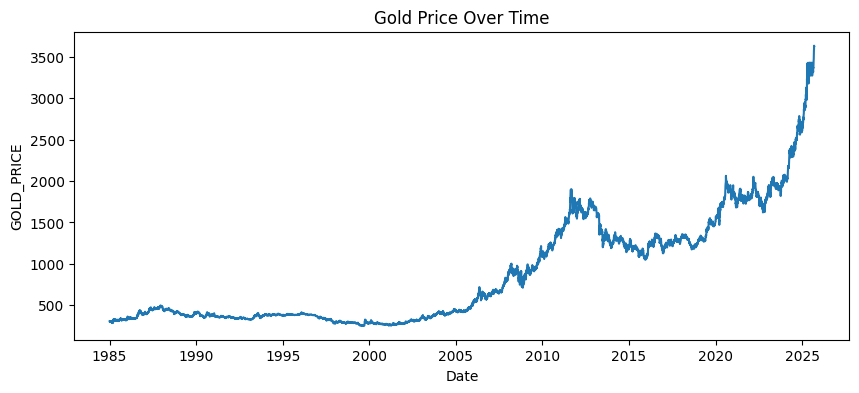

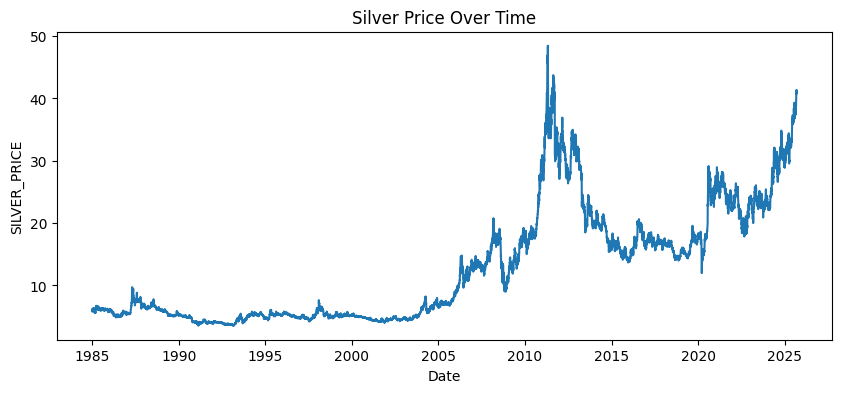

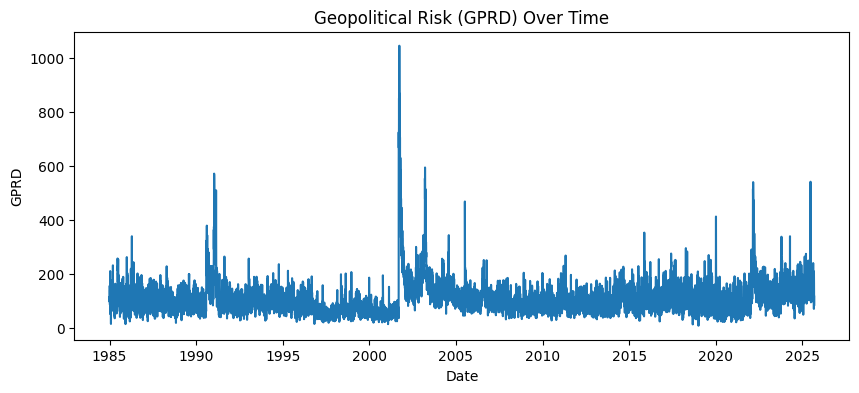

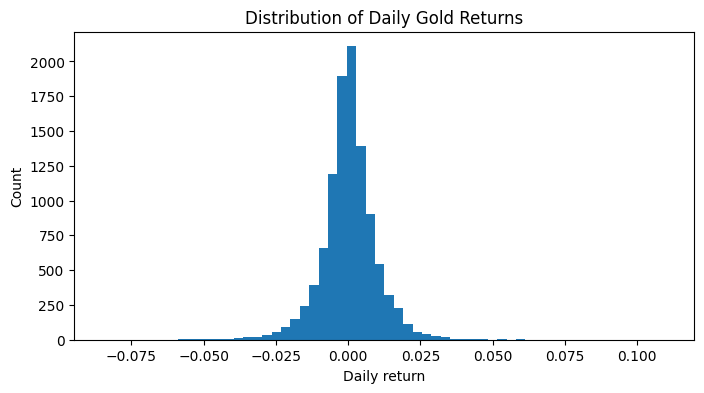

In [84]:
# Quick plots

plt.figure(figsize=(10,4))
plt.plot(df[DATE_COL], df[GOLD_COL])
plt.title("Gold Price Over Time")
plt.xlabel("Date"); plt.ylabel(GOLD_COL)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df[DATE_COL], df[SILV_COL])
plt.title("Silver Price Over Time")
plt.xlabel("Date"); plt.ylabel(SILV_COL)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df[DATE_COL], df[GPR_COL])
plt.title("Geopolitical Risk (GPRD) Over Time")
plt.xlabel("Date"); plt.ylabel(GPR_COL)
plt.show()

gold_ret = df[GOLD_COL].pct_change(1, fill_method=None)
plt.figure(figsize=(8,4))
plt.hist(gold_ret.dropna(), bins=60)
plt.title("Distribution of Daily Gold Returns")
plt.xlabel("Daily return"); plt.ylabel("Count")
plt.show()

## 4. Features

Engineered features (all based on past data only):
- Gold returns: 1/3/7 day
- Gold rolling mean/std: 7 day
- Silver return (1 day) and gold/silver ratio
- GPRD change: 1 day and 7 day

In [85]:
# Target + features

w = df[[DATE_COL, GOLD_COL, SILV_COL, GPR_COL]].copy()
w = w.sort_values(DATE_COL).reset_index(drop=True)

# Next-day direction label

future = w[GOLD_COL].shift(-1)
w["target_up_tomorrow"] = np.where(future.notna(), (future > w[GOLD_COL]).astype(int), np.nan)

w["gold_ret_1"] = w[GOLD_COL].pct_change(1, fill_method=None)
w["gold_ret_3"] = w[GOLD_COL].pct_change(3, fill_method=None)
w["gold_ret_7"] = w[GOLD_COL].pct_change(7, fill_method=None)

w["gold_roll_mean_7"] = w[GOLD_COL].rolling(7).mean()
w["gold_roll_std_7"]  = w[GOLD_COL].rolling(7).std()

w["silver_ret_1"] = w[SILV_COL].pct_change(1, fill_method=None)
w["gold_silver_ratio"] = w[GOLD_COL] / w[SILV_COL]

w["gpr_change_1"] = w[GPR_COL].diff(1)
w["gpr_change_7"] = w[GPR_COL].diff(7)

# Model inputs

FEATURES = [
    "gold_ret_1","gold_ret_3","gold_ret_7",
    "gold_roll_mean_7","gold_roll_std_7",
    "silver_ret_1","gold_silver_ratio",
    "gpr_change_1","gpr_change_7"
]

data = w.dropna(subset=FEATURES + ["target_up_tomorrow"]).copy()
data["target_up_tomorrow"] = data["target_up_tomorrow"].astype(int)

print("Usable rows:", data.shape)
print("Class balance:", data["target_up_tomorrow"].value_counts().to_dict())
display(data.head())

Usable rows: (10548, 14)
Class balance: {1: 5336, 0: 5212}


,DATE,GOLD_PRICE,SILVER_PRICE,GPRD,target_up_tomorrow,gold_ret_1,gold_ret_3,gold_ret_7,gold_roll_mean_7,gold_roll_std_7,silver_ret_1,gold_silver_ratio,gpr_change_1,gpr_change_7
7,1985-01-11,304.2,6.11,94.85,0,0.001317,0.007285,-0.004255,302.014286,2.084409,-0.004886,49.787234,-45.78,-20.83
8,1985-01-14,299.0,5.94,211.64,1,-0.017094,-0.004992,-0.010916,301.542857,2.363512,-0.027823,50.336700,116.79,114.21
9,1985-01-15,301.8,6.05,97.17,1,0.009365,-0.006583,-0.004289,301.357143,2.269991,0.018519,49.884298,-114.47,-60.20
10,1985-01-16,302.7,6.09,106.33,1,0.002982,-0.004931,0.015091,302.000000,1.819341,0.006612,49.704433,9.16,1.02
11,1985-01-17,305.5,6.18,54.69,1,0.009250,0.021739,0.011589,302.500000,2.249444,0.014778,49.433657,-51.64,-32.71


## 5. Evaluation

- Chronological split: first 80% train, last 20% test  
- Metrics: Accuracy, F1, ROC-AUC

In [86]:
# Time split (80/20)

X = data[FEATURES]
y = data["target_up_tomorrow"]

split_idx = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train date range:", data[DATE_COL].iloc[:split_idx].min(), "->", data[DATE_COL].iloc[:split_idx].max())
print("Test date range :", data[DATE_COL].iloc[split_idx:].min(), "->", data[DATE_COL].iloc[split_idx:].max())

Train size: (8438, 9) Test size: (2110, 9)
Train date range: 1985-01-11 00:00:00 -> 2017-07-25 00:00:00
Test date range : 2017-07-26 00:00:00 -> 2025-09-08 00:00:00


## 6. Baselines

- Momentum sign: predict UP if yesterday’s gold return > 0  
- Always-UP: predicts the majority class in the test period (good accuracy, poor DOWN detection)
- Majority(train): predicts the most common class in the training period

In [87]:
# Baseline: yesterday's sign

from sklearn.metrics import accuracy_score, f1_score

baseline_pred = (data["gold_ret_1"].iloc[split_idx:] > 0).astype(int)
baseline_acc = accuracy_score(y_test, baseline_pred)
baseline_f1  = f1_score(y_test, baseline_pred)

print("Baseline Acc:", baseline_acc)
print("Baseline F1 :", baseline_f1)

Baseline Acc: 0.466824644549763
Baseline F1 : 0.5054945054945055


In [88]:
# Naive baselines

from sklearn.metrics import accuracy_score, f1_score, classification_report

always_up = np.ones_like(y_test)
print("Always-UP Acc:", accuracy_score(y_test, always_up))
print("Always-UP F1 (pos class):", f1_score(y_test, always_up))
print("Always-UP report:\n", classification_report(y_test, always_up, zero_division=0))

majority_class = int(y_train.value_counts().idxmax())
majority_pred = np.full_like(y_test, fill_value=majority_class)
print("\nMajority(train) class:", majority_class)
print("Majority(train) Acc:", accuracy_score(y_test, majority_pred))
print("Majority(train) F1:", f1_score(y_test, majority_pred))

Always-UP Acc: 0.5388625592417061
Always-UP F1 (pos class): 0.7003387742531567
Always-UP report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       973
           1       0.54      1.00      0.70      1137

    accuracy                           0.54      2110
   macro avg       0.27      0.50      0.35      2110
weighted avg       0.29      0.54      0.38      2110


Majority(train) class: 0
Majority(train) Acc: 0.4611374407582938
Majority(train) F1: 0.0


In [89]:
# AUC helper

from sklearn.metrics import roc_auc_score
import numpy as np

def safe_auc(y_true, y_proba):
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_proba)

## 7. Models

Trained and compared:
- Logistic Regression (scaled)
- Random Forest
- Histogram Gradient Boosting

Hyperparameters are tuned using time-series cross-validation where applicable.

In [90]:
# Logistic Regression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])

lr.fit(X_train, y_train)

pred_lr  = lr.predict(X_test)
proba_lr = lr.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, pred_lr)
lr_f1  = f1_score(y_test, pred_lr)
lr_auc = safe_auc(y_test, proba_lr)

print("LogReg Acc:", lr_acc)
print("LogReg F1 :", lr_f1)
print("LogReg AUC:", lr_auc)
print("\nClassification report:\n", classification_report(y_test, pred_lr, zero_division=0))

LogReg Acc: 0.5374407582938389
LogReg F1 : 0.6303030303030303
LogReg AUC: 0.5229191693761462

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.31      0.38       973
           1       0.55      0.73      0.63      1137

    accuracy                           0.54      2110
   macro avg       0.53      0.52      0.51      2110
weighted avg       0.53      0.54      0.52      2110



In [91]:
# Tune LR (time-series CV)

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Time-ordered Folds to reduce Look-ahead

tscv = TimeSeriesSplit(n_splits=4)

lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 3, 10],
    "clf__class_weight": [None, "balanced"]
}

grid_lr = GridSearchCV(lr_pipe, param_grid, cv=tscv, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
tlr_pred  = best_lr.predict(X_test)
tlr_proba = best_lr.predict_proba(X_test)[:, 1]

tlr_acc = accuracy_score(y_test, tlr_pred)
tlr_f1  = f1_score(y_test, tlr_pred)
tlr_auc = safe_auc(y_test, tlr_proba)

print("Best LR params:", grid_lr.best_params_)
print("Tuned LR Acc:", tlr_acc)
print("Tuned LR F1 :", tlr_f1)
print("Tuned LR AUC:", tlr_auc)

Best LR params: {'clf__C': 3, 'clf__class_weight': None}
Tuned LR Acc: 0.5379146919431279
Tuned LR F1 : 0.6308216584627035
Tuned LR AUC: 0.5228784932852812


RF Acc: 0.4706161137440758
RF F1 : 0.31006794317479924
RF AUC: 0.49635813399789025


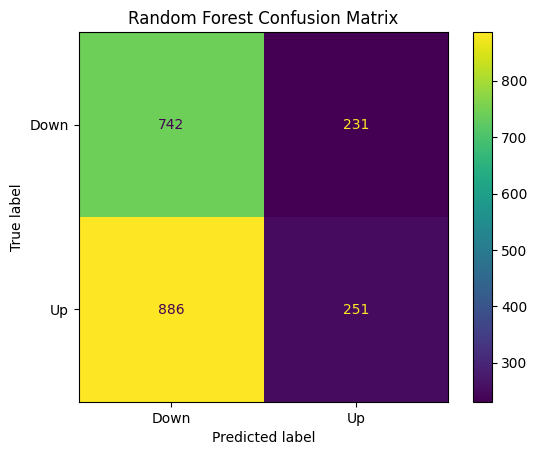

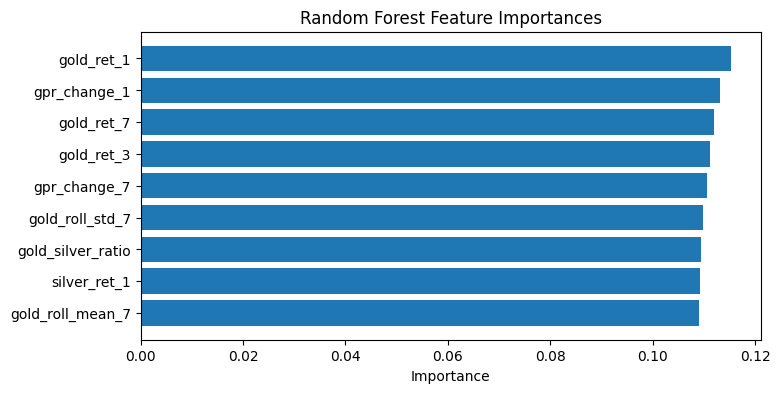

In [92]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

rf = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)

rf.fit(X_train, y_train)

pred_rf  = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, pred_rf)
rf_f1  = f1_score(y_test, pred_rf)
rf_auc = safe_auc(y_test, proba_rf)

print("RF Acc:", rf_acc)
print("RF F1 :", rf_f1)
print("RF AUC:", rf_auc)

ConfusionMatrixDisplay.from_predictions(y_test, pred_rf, display_labels=["Down","Up"])
plt.title("Random Forest Confusion Matrix")
plt.show()

# Feature Importance View

importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values()
plt.figure(figsize=(8,4))
plt.barh(importances.index, importances.values)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

In [93]:
# Tune RF (time-series CV)

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

tscv = TimeSeriesSplit(n_splits=4)

rf0 = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced_subsample")

param_dist = {
    "n_estimators": [300, 600, 900],
    "max_depth": [3, 5, 8, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", 0.5, 0.8]
}

search = RandomizedSearchCV(
    rf0,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=tscv,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)

best_rf = search.best_estimator_
trf_pred  = best_rf.predict(X_test)
trf_proba = best_rf.predict_proba(X_test)[:, 1]

trf_acc = accuracy_score(y_test, trf_pred)
trf_f1  = f1_score(y_test, trf_pred)
trf_auc = safe_auc(y_test, trf_proba)

print("Best RF params:", search.best_params_)
print("Tuned RF Acc:", trf_acc)
print("Tuned RF F1 :", trf_f1)
print("Tuned RF AUC:", trf_auc)

Best RF params: {'n_estimators': 300, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 3}
Tuned RF Acc: 0.5289099526066351
Tuned RF F1 : 0.5640350877192982
Tuned RF AUC: 0.5387322256781835


In [94]:
# Tune HGB

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)

param_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 5, None],
    "max_iter": [200, 400]
}

hgb = HistGradientBoostingClassifier(random_state=42)
grid = GridSearchCV(hgb, param_grid, scoring="accuracy", cv=tscv, n_jobs=-1)
grid.fit(X_train, y_train)

best_hgb = grid.best_estimator_

pred_hgb  = best_hgb.predict(X_test)
proba_hgb = best_hgb.predict_proba(X_test)[:, 1]

hgb_acc = accuracy_score(y_test, pred_hgb)
hgb_f1  = f1_score(y_test, pred_hgb)
hgb_auc = safe_auc(y_test, proba_hgb)

print("Best HGB params:", grid.best_params_)
print("HGB Acc:", hgb_acc)
print("HGB F1 :", hgb_f1)
print("HGB AUC:", hgb_auc)

Best HGB params: {'learning_rate': 0.03, 'max_depth': 3, 'max_iter': 200}
HGB Acc: 0.49146919431279623
HGB F1 : 0.28418945963975983
HGB AUC: 0.5215574242453004


## 8. Results

Results are reported on the hold-out test period. A confusion matrix is shown for the selected final model.

,Model,Accuracy,F1,ROC_AUC
0,Baseline (sign of gold_ret_1),0.466825,0.505495,NaN
1,Baseline (always UP),0.538863,0.700339,NaN
2,LogReg,0.537441,0.630303,0.522919
3,RF,0.470616,0.310068,0.496358
4,HGB,0.491469,0.284189,0.521557
5,Tuned LogReg,0.537915,0.630822,0.522878
6,Tuned RF,0.528910,0.564035,0.538732


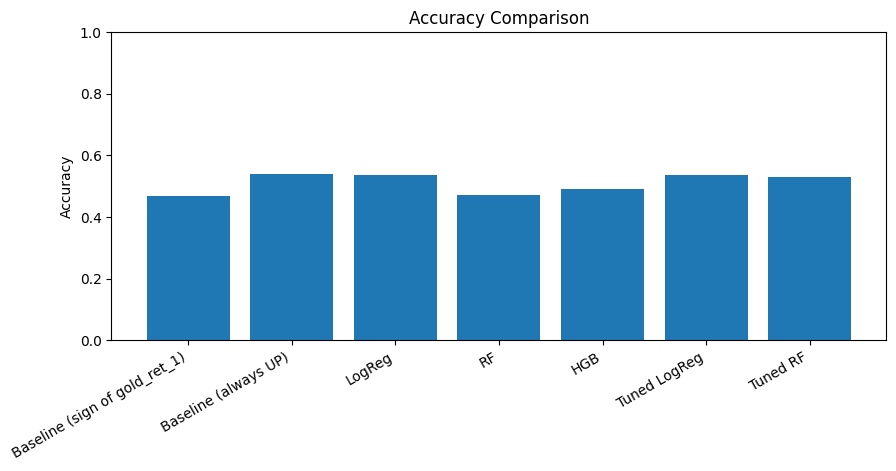

Selected best ML model: Tuned LogReg


In [95]:
# Compare models + pick best

rows = []

rows.append(["Baseline (sign of gold_ret_1)", baseline_acc, baseline_f1, np.nan])

always_up_acc = accuracy_score(y_test, always_up)
always_up_f1  = f1_score(y_test, always_up)

rows.append(["Baseline (always UP)", always_up_acc, always_up_f1, np.nan])
rows.append(["LogReg", lr_acc, lr_f1, lr_auc])
rows.append(["RF", rf_acc, rf_f1, rf_auc])
rows.append(["HGB", hgb_acc, hgb_f1, hgb_auc])

if "best_lr" in globals():
    rows.append(["Tuned LogReg", tlr_acc, tlr_f1, tlr_auc])
if "best_rf" in globals():
    rows.append(["Tuned RF", trf_acc, trf_f1, trf_auc])

results = pd.DataFrame(rows, columns=["Model","Accuracy","F1","ROC_AUC"])
display(results)

plt.figure(figsize=(10,4))
plt.bar(results["Model"], results["Accuracy"])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.show()

model_objects = {
    "LogReg": lr,
    "RF": rf,
    "HGB": best_hgb,
}
if "best_lr" in globals():
    model_objects["Tuned LogReg"] = best_lr
if "best_rf" in globals():
    model_objects["Tuned RF"] = best_rf

ml_names = list(model_objects.keys())
ml_results = results[results["Model"].isin(ml_names)].copy()

# Accuracy first, then F1

best_row = ml_results.sort_values(["Accuracy","F1"], ascending=False).iloc[0]
best_name = best_row["Model"]
print("Selected best ML model:", best_name)

best_model = model_objects[best_name]

## Discussion

Always-UP achieves 0.5389 accuracy by predicting only UP, but it does not identify DOWN days. The best ML model by the selection rule (Accuracy then F1) is **Tuned Logistic Regression**, scoring **0.5379 accuracy**, **0.6308 F1**, and **0.5229 ROC-AUC**. Tuning improves Random Forest substantially (to **0.5289 accuracy**, **0.5640 F1**) and yields the highest ROC-AUC (**0.5387**), but it does not beat tuned Logistic Regression on Accuracy/F1.

In [96]:
# Save outputs

import joblib

joblib.dump(best_model, "/kaggle/working/best_model.joblib")
results.to_csv("/kaggle/working/results_summary.csv", index=False)

pred_best = best_model.predict(X_test)
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, pred_best, display_labels=["Down","Up"])
plt.title(f"Confusion Matrix - {best_name}")
plt.savefig("/kaggle/working/confusion_matrix_best.png", bbox_inches="tight")
plt.close()

print("Saved to /kaggle/working/:")
print(" - best_model.joblib")
print(" - results_summary.csv")
print(" - confusion_matrix_best.png")

Saved to /kaggle/working/:
 - best_model.joblib
 - results_summary.csv
 - confusion_matrix_best.png


## 9. Gradio Demo

Select a date and the app outputs the model’s next-day UP/DOWN prediction and the UP probability.

In [97]:
# Install Gradio

!pip -q install "packaging<26" gradio

In [98]:
# Gradio demo

import gradio as gr

data["_date_str"] = data[DATE_COL].dt.strftime("%Y-%m-%d")
date_choices = data["_date_str"].tolist()

# Predict for selected date

def predict_by_date(date_str):
    row = data.loc[data["_date_str"] == date_str]
    if row.empty:
        return "Date not found", 0.0, "N/A"

    X_row = row[FEATURES].iloc[0:1]
    proba_up = float(best_model.predict_proba(X_row)[0, 1])
    pred_label = "UP" if proba_up >= 0.5 else "DOWN"

    actual = int(row["target_up_tomorrow"].iloc[0])
    actual_label = "UP" if actual == 1 else "DOWN"

    return pred_label, proba_up, actual_label

demo = gr.Interface(
    fn=predict_by_date,
    inputs=gr.Dropdown(choices=date_choices, label="Date"),
    outputs=[
        gr.Textbox(label="Predicted Next-Day Direction"),
        gr.Number(label="Probability (Up)"),
        gr.Textbox(label="Actual Next-Day Direction")
    ],
    title="Gold Direction Predictor (Next-Day Up/Down)",
)

demo.launch(share=True, inline=True)

* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://3594ac37e02dc0059a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 10. Limitations

- Next-day direction is noisy, so gains are small.
- Only price dynamics + GPRD are used (no macro/news features).
- Metrics do not imply trading profitability (costs/risk not modeled).